#Access Pre-processed data
 Reading the pre-processed athletic_data dataframe

In [1]:
import matplotlib.pyplot as plt
%store -r athletic_data
data = athletic_data

#Removing rows with mismatch in heartrate and power rows length mismatch.
activity_data = data[data.apply(lambda row: len(row['heartrate']) == len(row['power']), axis=1)]

# Flag to keep track of mismatch
mismatch_found = False

for index, row in activity_data.iterrows():
    hr_length = len(row['heartrate'])
    pow_length = len(row['power'])
    if hr_length != pow_length:
        print(f"Mismatch found in row {index+1}: Length of 'hr' column is {hr_length}, Length of 'pow' column is {pow_length}")
        mismatch_found = True

if not mismatch_found:
    print("No mismatch found")

No mismatch found


#STEP 1 : Visualizing the original data by plotting it with pandas

In [ ]:

for index, row in activity_data.iterrows():
    hr_values = row['heartrate']
    pow_values = row['power']
    plt.scatter(pow_values, hr_values)
    # Set x-axis limits
    #plt.xlim(0, max(pow_values))  # Set the lower limit as 0 and the upper limit as the maximum value of x-axis param


plt.xlabel('Power')
plt.ylabel('Heart Rate')
plt.title('ScatterPlot of Heartrate and Power')
plt.legend()
plt.show()


#STEP 2 : Visualizing the heartrate and power data in separate histograms


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Flatten the 'heartrate' and 'power' columns
heartrate_flat = np.concatenate(activity_data['heartrate'].values)
power_flat = np.concatenate(activity_data['power'].values)

# Create subplots for the histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Plot the histogram of heartrate
ax1.hist(heartrate_flat, bins='auto')
ax1.set_xlabel('Heartrate')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of Heartrate')

# Set x-axis limit for better visibility of data close to zero
ax1.set_ylim(bottom=0)

# Plot the histogram of power
ax2.hist(power_flat, bins='auto')
ax2.set_xlabel('Power')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of Power')

# Set x-axis limit for better visibility of data close to zero
ax2.set_ylim(bottom=0)
# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


# Evaluating the HR derivative using functional analysis regression

In [2]:
import numpy as np

# Function to calculate HR derivative for a single list of heart rate values
def calculate_hr_derivative(hr_list):
    return np.gradient(hr_list)

# Apply HR derivative calculation to the DataFrame
activity_data['hr_derivative'] = activity_data['heartrate'].apply(calculate_hr_derivative)

/var/folders/_v/5f3z26jn5yx0g4w1cr9x3kb80000gn/T/ipykernel_45355/2027298663.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  activity_data['hr_derivative'] = activity_data['heartrate'].apply(calculate_hr_derivative)


# Performing a multilevel linear regression between 𝐻𝑅̇(t), 𝐻𝑅(𝑡) and 𝑃(𝑡)

In [24]:
import statsmodels.api as sm

# Check lengths of columns
column_lengths = activity_data.apply(lambda x: len(x))
if not column_lengths.nunique() == 1:
    raise ValueError("Columns have inconsistent lengths.")

# Explode the heartrate and hr_derivative columns to flatten the nested lists
activity_data_exploded = activity_data.explode(['heartrate', 'hr_derivative', 'power'])

# Convert columns to numpy arrays
heartrate = np.array(activity_data_exploded['heartrate'], dtype=np.int64)
hr_derivative = np.array(activity_data_exploded['hr_derivative'], dtype=np.float64)
power = np.array(activity_data_exploded['power'], dtype=np.float64)

# Add constant column for the intercept term
intercept = np.ones((len(activity_data_exploded), 1))

# Concatenate the input arrays
X = np.concatenate((intercept, hr_derivative[:, np.newaxis], power[:, np.newaxis]), axis=1)
y = heartrate

# Fit the multilevel linear regression model
model = sm.OLS(y, X)
results = model.fit()

# Print the regression results
print(results.summary())

HR_0 = results.params[0]
decay_rate = results.params[1]
K = results.params[2]
print("HeartRate at t=0 : " , HR_0)
print("DecayRate : " , decay_rate)
print("K(Gain) : " , K)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                 4.060e+05
Date:                Thu, 15 Jun 2023   Prob (F-statistic):               0.00
Time:                        01:11:08   Log-Likelihood:            -1.0432e+07
No. Observations:             2353838   AIC:                         2.086e+07
Df Residuals:                 2353835   BIC:                         2.086e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         97.7433      0.027   3654.948      0.0

# Plot Relationship

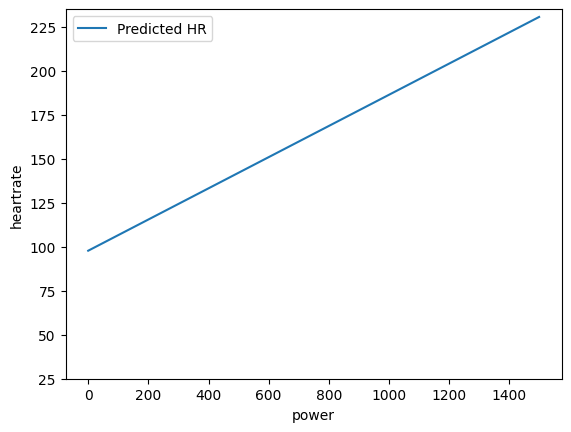

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have already obtained the values of the coefficients

# Generate a range of values for the power variable
power_range = np.linspace(min(power), max(power), 100)

# Calculate the predicted heart rate using the model equation
predicted_hr = HR_0 + decay_rate * hr_derivative.mean() + K * power_range

# Plot the predicted heart rate
plt.plot(power_range, predicted_hr, label='Predicted HR')

# Set the y-axis range with equal increments
plt.ylim(min(heartrate) - 5, max(heartrate) + 5)

# Add labels and a legend
plt.xlabel('power')
plt.ylabel('heartrate')
plt.legend()

# Display the plot
plt.show()


In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Create an empty DataFrame to store expanded data
expanded_data = pd.DataFrame()

# Iterate over each row in the DataFrame
for _, row in activity_data.iterrows():
    x_values = row['heartrate']
    y_values = row['power']

    # Create a DataFrame with the expanded sequence for this row
    row_data = pd.DataFrame({'heartrate': x_values, 'power': y_values})

    # Append the row data to the expanded_data DataFrame
    expanded_data = pd.concat([expanded_data, row_data], ignore_index=True)

# Separate the features (X) and target variable (Y)
X = expanded_data[['heartrate']]
Y = expanded_data[['power']]

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Create an instance of the linear regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, Y_train)

# Evaluate the model on the testing data
score = model.score(X_test, Y_test)

# Perform predictions on new data
new_X = [70, 100, 130, 155]  # Input new X values
new_X = pd.DataFrame({'heartrate': new_X})
predictions = model.predict(new_X)


In [ ]:
import matplotlib.pyplot as plt  # To visualize

# Plot the graph
plt.scatter(new_X['heartrate'], predictions, color='blue', label='Predicted Power')
plt.xlabel('heartrate')
plt.ylabel('power')
plt.title('Linear Regression Predictions')
plt.legend()
plt.show()